# Data formatting for STGAN
# `dataset3`
## Setup

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from numba import jit

## Cameras

In [2]:
cams = pd.read_csv("traffic_data/dataset1/CamerasGPSinfo.csv")
cams

,CamId,Longitude,Latitude,Bearing
0,1,11.986280,57.697137,155
1,2,11.985522,57.696668,85
2,4,11.965964,57.706792,90
3,5,11.977686,57.708775,175
4,6,11.972374,57.707239,60
...,...,...,...,...
129,115,11.968668,57.701172,240
130,116,11.968668,57.701172,60
131,117,11.967943,57.700256,250
132,118,11.967943,57.700256,70


### Locations

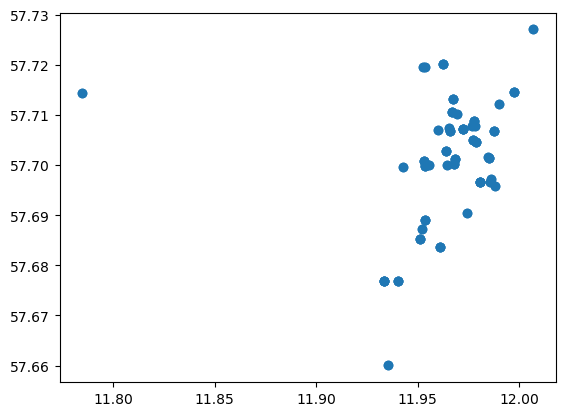

In [3]:
plt.scatter(cams.Longitude, cams.Latitude)

## Data

In [4]:
raw = pd.read_pickle("traffic_data/dataset3/dens_0401")
raw.columns = raw.columns.map(lambda x: "Cam" + x[x.find("Cam") + 3:])
day_number = 0 # The first file from the files dens_*

We are missing some hours during the night, so we will set those to 0.

Per day we will have $24 \text{ hours} \times 60 \text{ minutes} = 1440 \text{ minutes}$.

### Merge all data

In [5]:
start_date = datetime.date(2020, 4, 1)
end_date = datetime.date(2020, 11, 23)

In [6]:
(end_date - start_date).days

236

In [7]:
number_of_days = (end_date - start_date).days + 1 # Include the end date
data = pd.DataFrame([])
data["Timestamp"] = range(1440 * number_of_days)
data

,Timestamp
0,0
1,1
2,2
3,3
4,4
...,...
341275,341275
341276,341276
341277,341277
341278,341278


In [8]:
def concatenate_files():
    progress_bar = tqdm(total=number_of_days, desc="Concatenating files", unit="files")

    current_date = start_date

    day_number = 0
    while current_date <= end_date:
        month = current_date.strftime("%m")
        day = current_date.strftime("%d")
        raw_path = "traffic_data/dataset3/dens_" + month + day
        if os.path.exists(raw_path):
            raw = pd.read_pickle(raw_path)
            raw.columns = raw.columns.map(lambda x: "Cam" + x[x.find("Cam") + 3:])
            for camera in raw.columns:
                camera_data = raw[camera].dropna()
                density = [x[1] for x in camera_data]
                times = [x[0] for x in camera_data]
                for index, time in enumerate(times):
                    hour = int(time[:2])
                    minute = int(time[2:4])
                    data.loc[day_number*1440 + hour*60 + minute, camera] = density[index]
                # print(data.loc[camera_data.apply(lambda x: day_number*1440 + int(x[0][0:2])*60 + int(x[0][2:4])), camera])

        current_date += datetime.timedelta(days=1)
        day_number += 1
        progress_bar.update(1)

    progress_bar.close()

concatenate_files()

data = data[data>=0]
# Set the leftmost values to zero, since we are doing a forward fill
data.iloc[0] = 0
# Fill NaN values by propagating the last valid observation to next valid,
# with limit=10 (arbitrary) as the maximum number of consecutive NaN values
data.fillna(method="ffill", limit=10, inplace=True)
# Fill the remaining NaN values with zeroes, representing the values during the night 
data.fillna(0, inplace=True)

Concatenating files: 100%|██████████| 237/237 [20:41<00:00,  5.24s/files]
/tmp/ipykernel_3955469/1387903568.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", limit=10, inplace=True)


In [9]:
data

,Timestamp,Cam2,Cam4,Cam7,Cam10,Cam14,Cam15,Cam20,Cam23,Cam24,...,Cam114,Cam115,Cam116,Cam111,Cam112,Cam79,Cam5,Cam16,Cam17,Cam113
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341275,341275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
341276,341276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
341277,341277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
341278,341278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

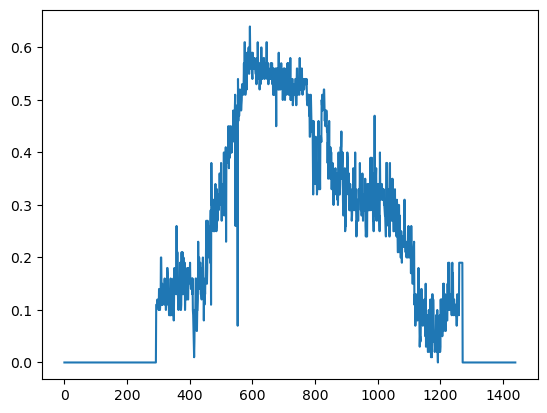

In [10]:
data.Cam2[:1440].plot()

In [11]:
smooth_int = 5
smooth_len = int(data.shape[0]/smooth_int)
smooth_len

68256

In [12]:
data_smooth = pd.DataFrame([], columns=data.columns, dtype=float)
data_smooth["Timestamp"] = range(smooth_len)
data_smooth

,Timestamp,Cam2,Cam4,Cam7,Cam10,Cam14,Cam15,Cam20,Cam23,Cam24,...,Cam114,Cam115,Cam116,Cam111,Cam112,Cam79,Cam5,Cam16,Cam17,Cam113
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68251,68251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68252,68252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68253,68253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68254,68254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
data.drop(["Timestamp"], axis=1, inplace=True)

In [14]:
from numba import jit
from tqdm import tqdm

@jit(nopython=True)  # Decorate your function with @jit
def smooth_data(data, smooth_len, smooth_int):
    num_rows = data.shape[0]
    num_cols = data.shape[1]
    smoothed_data = np.zeros((smooth_len, num_cols))  # Initialize smoothed data array

    for col in range(num_cols):
        for i in range(smooth_len):
            start_idx = i * smooth_int
            end_idx = (i + 1) * smooth_int
            for j in range(start_idx, end_idx):
                smoothed_data[i, col] += data[j, col]
            smoothed_data[i, col] /= smooth_int

    return smoothed_data

# Call the smoothed_data function
smoothed_data = smooth_data(data.values, smooth_len, smooth_int)

# Convert the smoothed data array back to a DataFrame
data_smooth = pd.DataFrame(smoothed_data, columns=data.columns)

In [15]:
data_smooth

,Cam2,Cam4,Cam7,Cam10,Cam14,Cam15,Cam20,Cam23,Cam24,Cam25,...,Cam114,Cam115,Cam116,Cam111,Cam112,Cam79,Cam5,Cam16,Cam17,Cam113
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

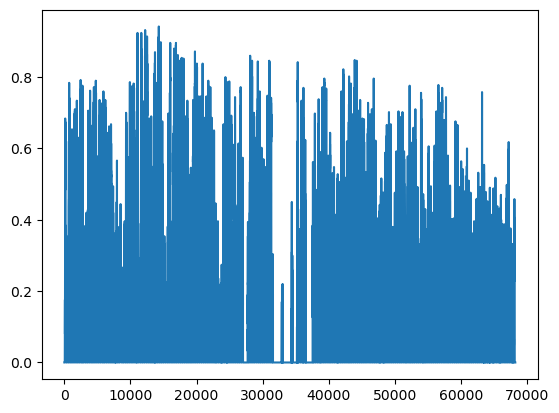

In [16]:
data_smooth.Cam116.plot()

<Axes: >

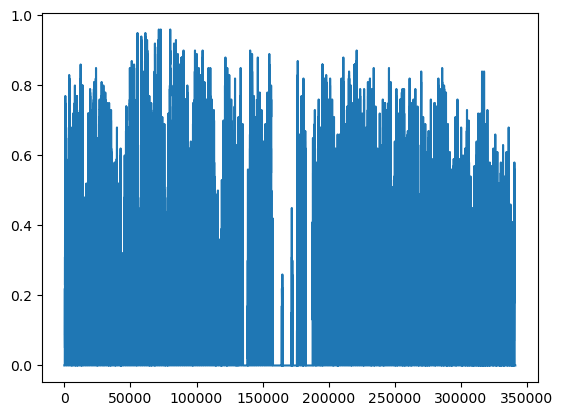

In [17]:
data.Cam116.plot()

<Axes: >

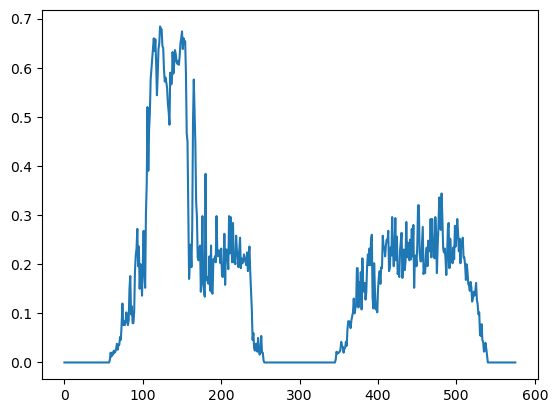

In [18]:
data_smooth.Cam116[:288*2].plot()

<Axes: >

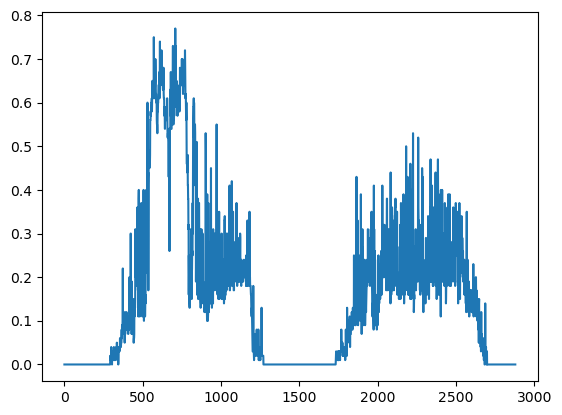

In [19]:
data.Cam116[:288*5*2].plot()

In [20]:
os.makedirs("stgan-algo/STGAN/ximantis_smooth_3_truncated/data", exist_ok=True)

In [21]:
# Save
np.save("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/data.npy", data_smooth)

In [22]:
data_tensor = torch.tensor(np.load("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/data.npy"), dtype=torch.float)
data_tensor.shape

torch.Size([68256, 42])

In [23]:
data_tensor = data_tensor.reshape([data_tensor.shape[0], data_tensor.shape[1], 1, 1])
data_tensor.shape

torch.Size([68256, 42, 1, 1])

In [24]:
# Save
# np.save("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/data.npy", data_tensor.repeat([1,1,1,2]).numpy())
np.save("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/data.npy", data_tensor.numpy())

## Node distances

In [25]:
cams

,CamId,Longitude,Latitude,Bearing
0,1,11.986280,57.697137,155
1,2,11.985522,57.696668,85
2,4,11.965964,57.706792,90
3,5,11.977686,57.708775,175
4,6,11.972374,57.707239,60
...,...,...,...,...
129,115,11.968668,57.701172,240
130,116,11.968668,57.701172,60
131,117,11.967943,57.700256,250
132,118,11.967943,57.700256,70


In [26]:
cameras_used = data.columns.map(lambda x: int(x[3:]))

In [27]:
cameras_used = list(cameras_used)

In [28]:
dists = pd.DataFrame(columns=cameras_used, index=cameras_used)
dists

,2,4,7,10,14,15,20,23,24,25,...,114,115,116,111,112,79,5,16,17,113
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
radius = 6_400
for i in cameras_used:
    for j in cameras_used:
        dx = (cams.Longitude[i] - cams.Longitude[j]) * 2 * np.pi / 360 * radius
        dy = (cams.Latitude[i] - cams.Latitude[j]) * 2 * np.pi / 360 * radius
        dists.loc[i,j] = np.sqrt(dx**2 + dy**2)

In [30]:
dists

,2,4,7,10,14,15,20,23,24,25,...,114,115,116,111,112,79,5,16,17,113
2,0.0,0.717743,0.436629,0.066994,1.327964,2.05584,0.73866,1.996125,0.527483,4.933882,...,1.554838,1.554838,2.914142,6.246701,4.414757,2.419454,0.717743,1.398109,2.242567,4.414757
4,0.717743,0.0,0.688644,0.746783,0.617664,1.885991,0.867626,1.506744,0.466145,5.513786,...,1.834452,1.834452,3.403247,6.705549,4.946503,1.703995,0.0,0.680382,1.584234,4.946503
7,0.436629,0.688644,0.0,0.392115,1.192621,2.383023,0.305747,2.166028,0.248252,5.31711,...,1.211443,1.211443,3.335464,6.668337,4.819473,2.32312,0.688644,1.29961,2.268323,4.819473
10,0.066994,0.746783,0.392115,0.0,1.34983,2.122833,0.68884,2.055636,0.511737,4.951857,...,1.489405,1.489405,2.946911,6.279906,4.440216,2.450737,0.746783,1.425657,2.288618,4.440216
14,1.327964,0.617664,1.192621,1.34983,0.0,2.073093,1.248351,1.403106,0.944467,6.091939,...,2.14038,2.14038,3.948823,7.216022,5.503181,1.130719,0.617664,0.145148,1.183065,5.503181
15,2.05584,1.885991,2.383023,2.122833,2.073093,0.0,2.66077,0.961879,2.265254,4.835223,...,3.589654,3.589654,2.651389,5.546546,4.128391,2.342277,1.885991,1.974372,1.716682,4.128391
20,0.73866,0.867626,0.305747,0.68884,1.248351,2.66077,0.0,2.374105,0.409569,5.557605,...,0.967552,0.967552,3.613073,6.943947,5.07945,2.364795,0.867626,1.375191,2.392905,5.07945
23,1.996125,1.506744,2.166028,2.055636,1.403106,0.961879,2.374105,0.0,1.968422,5.711488,...,3.341196,3.341196,3.505369,6.502339,5.026878,1.390713,1.506744,1.270019,0.754893,5.026878
24,0.527483,0.466145,0.248252,0.511737,0.944467,2.265254,0.409569,1.968422,0.0,5.461083,...,1.375986,1.375986,3.432568,6.763035,4.940605,2.074886,0.466145,1.051802,2.030561,4.940605
25,4.933882,5.513786,5.31711,4.951857,6.091939,4.835223,5.557605,5.711488,5.461083,0.0,...,5.813925,5.813925,2.20825,1.903119,0.755629,6.917207,5.513786,6.093946,6.410982,0.755629


In [31]:
dists.to_csv("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/node_dist.txt", sep=" ", header=False, index=False)

## Adjacent nodes

In [32]:
dists

,2,4,7,10,14,15,20,23,24,25,...,114,115,116,111,112,79,5,16,17,113
2,0.0,0.717743,0.436629,0.066994,1.327964,2.05584,0.73866,1.996125,0.527483,4.933882,...,1.554838,1.554838,2.914142,6.246701,4.414757,2.419454,0.717743,1.398109,2.242567,4.414757
4,0.717743,0.0,0.688644,0.746783,0.617664,1.885991,0.867626,1.506744,0.466145,5.513786,...,1.834452,1.834452,3.403247,6.705549,4.946503,1.703995,0.0,0.680382,1.584234,4.946503
7,0.436629,0.688644,0.0,0.392115,1.192621,2.383023,0.305747,2.166028,0.248252,5.31711,...,1.211443,1.211443,3.335464,6.668337,4.819473,2.32312,0.688644,1.29961,2.268323,4.819473
10,0.066994,0.746783,0.392115,0.0,1.34983,2.122833,0.68884,2.055636,0.511737,4.951857,...,1.489405,1.489405,2.946911,6.279906,4.440216,2.450737,0.746783,1.425657,2.288618,4.440216
14,1.327964,0.617664,1.192621,1.34983,0.0,2.073093,1.248351,1.403106,0.944467,6.091939,...,2.14038,2.14038,3.948823,7.216022,5.503181,1.130719,0.617664,0.145148,1.183065,5.503181
15,2.05584,1.885991,2.383023,2.122833,2.073093,0.0,2.66077,0.961879,2.265254,4.835223,...,3.589654,3.589654,2.651389,5.546546,4.128391,2.342277,1.885991,1.974372,1.716682,4.128391
20,0.73866,0.867626,0.305747,0.68884,1.248351,2.66077,0.0,2.374105,0.409569,5.557605,...,0.967552,0.967552,3.613073,6.943947,5.07945,2.364795,0.867626,1.375191,2.392905,5.07945
23,1.996125,1.506744,2.166028,2.055636,1.403106,0.961879,2.374105,0.0,1.968422,5.711488,...,3.341196,3.341196,3.505369,6.502339,5.026878,1.390713,1.506744,1.270019,0.754893,5.026878
24,0.527483,0.466145,0.248252,0.511737,0.944467,2.265254,0.409569,1.968422,0.0,5.461083,...,1.375986,1.375986,3.432568,6.763035,4.940605,2.074886,0.466145,1.051802,2.030561,4.940605
25,4.933882,5.513786,5.31711,4.951857,6.091939,4.835223,5.557605,5.711488,5.461083,0.0,...,5.813925,5.813925,2.20825,1.903119,0.755629,6.917207,5.513786,6.093946,6.410982,0.755629


### Reset indices of nodes

In [33]:
dists = pd.read_csv("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/node_dist.txt", delimiter=" ", names=range(len(cameras_used)))
dists

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.000000,0.717743,0.436629,0.066994,1.327964,2.055840,0.738660,1.996125,0.527483,4.933882,...,1.554838,1.554838,2.914142,6.246701,4.414757,2.419454,0.717743,1.398109,2.242567,4.414757
1,0.717743,0.000000,0.688644,0.746783,0.617664,1.885991,0.867626,1.506744,0.466145,5.513786,...,1.834452,1.834452,3.403247,6.705549,4.946503,1.703995,0.000000,0.680382,1.584234,4.946503
2,0.436629,0.688644,0.000000,0.392115,1.192621,2.383023,0.305747,2.166028,0.248252,5.317110,...,1.211443,1.211443,3.335464,6.668337,4.819473,2.323120,0.688644,1.299610,2.268323,4.819473
3,0.066994,0.746783,0.392115,0.000000,1.349830,2.122833,0.688840,2.055636,0.511737,4.951857,...,1.489405,1.489405,2.946911,6.279906,4.440216,2.450737,0.746783,1.425657,2.288618,4.440216
4,1.327964,0.617664,1.192621,1.349830,0.000000,2.073093,1.248351,1.403106,0.944467,6.091939,...,2.140380,2.140380,3.948823,7.216022,5.503181,1.130719,0.617664,0.145148,1.183065,5.503181
5,2.055840,1.885991,2.383023,2.122833,2.073093,0.000000,2.660770,0.961879,2.265254,4.835223,...,3.589654,3.589654,2.651389,5.546546,4.128391,2.342277,1.885991,1.974372,1.716682,4.128391
6,0.738660,0.867626,0.305747,0.688840,1.248351,2.660770,0.000000,2.374105,0.409569,5.557605,...,0.967552,0.967552,3.613073,6.943947,5.079450,2.364795,0.867626,1.375191,2.392905,5.079450
7,1.996125,1.506744,2.166028,2.055636,1.403106,0.961879,2.374105,0.000000,1.968422,5.711488,...,3.341196,3.341196,3.505369,6.502339,5.026878,1.390713,1.506744,1.270019,0.754893,5.026878
8,0.527483,0.466145,0.248252,0.511737,0.944467,2.265254,0.409569,1.968422,0.000000,5.461083,...,1.375986,1.375986,3.432568,6.763035,4.940605,2.074886,0.466145,1.051802,2.030561,4.940605
9,4.933882,5.513786,5.317110,4.951857,6.091939,4.835223,5.557605,5.711488,5.461083,0.000000,...,5.813925,5.813925,2.208250,1.903119,0.755629,6.917207,5.513786,6.093946,6.410982,0.755629


### For one node

In [34]:
# The first 9 nearest neighbours
knn = 9
dists.loc[2].sort_values()[:knn].index

Index([19, 2, 8, 6, 3, 0, 1, 38, 18], dtype='int64')

In [35]:
dists.loc[2].sort_values()[:knn].index

Index([19, 2, 8, 6, 3, 0, 1, 38, 18], dtype='int64')

In [36]:
adj = pd.DataFrame([], columns=range(knn))
adj.loc[2] = list(dists.loc[2].sort_values()[:knn].index)
adj

,0,1,2,3,4,5,6,7,8
2,19,2,8,6,3,0,1,38,18


In [37]:
adj = pd.DataFrame([], columns=range(knn))
for i in range(len(cameras_used)):
    adj.loc[i] = list(dists.loc[i].sort_values()[:knn].index)
adj

,0,1,2,3,4,5,6,7,8
0,0,3,2,19,30,29,8,1,38
1,18,1,38,8,4,21,39,19,2
2,19,2,8,6,3,0,1,38,18
3,3,0,19,2,8,30,29,6,1
4,4,21,39,1,38,18,8,20,37
5,5,7,27,12,40,29,30,18,1
6,6,2,19,8,3,0,1,18,38
7,7,40,5,39,20,37,4,21,1
8,8,2,19,6,1,18,38,3,0
9,9,24,10,23,15,14,41,36,13


In [38]:
adj.to_csv("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/node_adjacent.txt", sep=" ", header=False, index=False)

## Node subgraph

In [39]:
stdev = np.array(dists).std()
stdev

3.9830436117637107

In [40]:
# Consider cameras adjacent only when they are closer that 0.5 km
dists = dists[dists<0.5]
dists = dists.fillna(1000000)

In [41]:
W = np.exp(-dists**2/stdev**2)
for i in range(len(W)):
    W.loc[i,i] = 0   
W

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.000000,0.000000,0.988055,0.999717,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.986397,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0
2,0.988055,0.000000,0.000000,0.990355,0.000000,0.0,0.994125,0.0,0.996123,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.999717,0.000000,0.990355,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.998673,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
6,0.000000,0.000000,0.994125,0.000000,0.000000,0.0,0.000000,0.0,0.989482,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
8,0.000000,0.986397,0.996123,0.000000,0.000000,0.0,0.989482,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.986397,0.000000,0.0,0.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [42]:
W.loc[adj.loc[0], adj.loc[0]]

,0,3,2,19,30,29,8,1,38
0,0.000000,0.999717,0.988055,0.988055,0.984619,0.984619,0.000000,0.000000,0.000000
3,0.999717,0.000000,0.990355,0.990355,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.988055,0.990355,0.000000,1.000000,0.000000,0.000000,0.996123,0.000000,0.000000
19,0.988055,0.990355,1.000000,0.000000,0.000000,0.000000,0.996123,0.000000,0.000000
30,0.984619,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
29,0.984619,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.996123,0.996123,0.000000,0.000000,0.000000,0.986397,0.986397
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.986397,0.000000,1.000000
38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.986397,1.000000,0.000000


In [43]:
np.exp(-(dists.loc[adj.loc[0], adj.loc[0]]**2 / stdev**2))

,0,3,2,19,30,29,8,1,38
0,1.000000,0.999717,0.988055,0.988055,0.984619,0.984619,0.000000,0.000000,0.000000
3,0.999717,1.000000,0.990355,0.990355,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.988055,0.990355,1.000000,1.000000,0.000000,0.000000,0.996123,0.000000,0.000000
19,0.988055,0.990355,1.000000,1.000000,0.000000,0.000000,0.996123,0.000000,0.000000
30,0.984619,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
29,0.984619,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.996123,0.996123,0.000000,0.000000,1.000000,0.986397,0.986397
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.986397,1.000000,1.000000
38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.986397,1.000000,1.000000


In [44]:
test = W.loc[adj.loc[0], adj.loc[0]]

In [45]:
torch.from_numpy(test.to_numpy())

tensor([[0.0000, 0.9997, 0.9881, 0.9881, 0.9846, 0.9846, 0.0000, 0.0000, 0.0000],
        [0.9997, 0.0000, 0.9904, 0.9904, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9881, 0.9904, 0.0000, 1.0000, 0.0000, 0.0000, 0.9961, 0.0000, 0.0000],
        [0.9881, 0.9904, 1.0000, 0.0000, 0.0000, 0.0000, 0.9961, 0.0000, 0.0000],
        [0.9846, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.9846, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9961, 0.9961, 0.0000, 0.0000, 0.0000, 0.9864, 0.9864],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9864, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9864, 1.0000, 0.0000]],
       dtype=torch.float64)

In [46]:
node_subgraph = torch.empty((len(cameras_used), knn, knn))
node_subgraph.shape

torch.Size([42, 9, 9])

In [47]:
for i in range(len(cameras_used)):
    node_subgraph[i,:,:] = torch.from_numpy(W.loc[adj.loc[i], adj.loc[i]].to_numpy())

In [48]:
node_subgraph.shape

torch.Size([42, 9, 9])

In [49]:
node_subgraph[0,:,:]

tensor([[0.0000, 0.9997, 0.9881, 0.9881, 0.9846, 0.9846, 0.0000, 0.0000, 0.0000],
        [0.9997, 0.0000, 0.9904, 0.9904, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9881, 0.9904, 0.0000, 1.0000, 0.0000, 0.0000, 0.9961, 0.0000, 0.0000],
        [0.9881, 0.9904, 1.0000, 0.0000, 0.0000, 0.0000, 0.9961, 0.0000, 0.0000],
        [0.9846, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.9846, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9961, 0.9961, 0.0000, 0.0000, 0.0000, 0.9864, 0.9864],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9864, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9864, 1.0000, 0.0000]])

In [50]:
np.save("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/node_subgraph.npy", node_subgraph.numpy())

## Time feature

In [51]:
time_features = np.zeros([data_smooth.shape[0], 24 + 7])

In [52]:
time_features = pd.DataFrame(time_features, dtype=int)

In [53]:
time_features

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# Hour one-hot encoding
timestamp = 12
day_length = 24 * 12
for i in range(len(time_features)):
    hour = divmod(divmod(i, day_length)[1], timestamp)[0]
    time_features.loc[i, hour] = 1

In [55]:
# Day one-hot encoding
timestamp = 12
day_length = 24 * 12
week_length = 7
starting_day = 2 # The starting day, april 1, 2020, is Wednesday
for i in range(len(time_features)):
    weekday = divmod(divmod(i, day_length)[0], week_length)[1]
    time_features.loc[i, 24 + divmod(starting_day + weekday, week_length)[1]] = 1
    # time_features.loc[i, 24 + weekday] = 1

In [56]:
time_features

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68251,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
68252,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
68253,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
68254,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [57]:
time_features.to_csv("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/time_features.txt", sep=" ", header=False, index=False)

## Truncation
### Data

In [58]:
data_tensor = torch.tensor(np.load("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/data.npy"), dtype=torch.float)
data_tensor.shape

torch.Size([68256, 42, 1, 1])

In [59]:
data_tensor = torch.tensor(np.load("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/data.npy"), dtype=torch.float)
data_tensor = data_tensor.reshape([data_tensor.shape[0], data_tensor.shape[1]])
df = pd.DataFrame(data_tensor)
df["Timestamp"] = df.index
df

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,Timestamp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68251
68252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68252
68253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68253
68254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68254


In [60]:
condition = (divmod(df['Timestamp'], 288)[1] <= 58) | (divmod(df['Timestamp'], 288)[1] > 252) # Exclude 58 (4:50), include 252 (21:00)

In [61]:
df

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,Timestamp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68251
68252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68252
68253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68253
68254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68254


<Axes: >

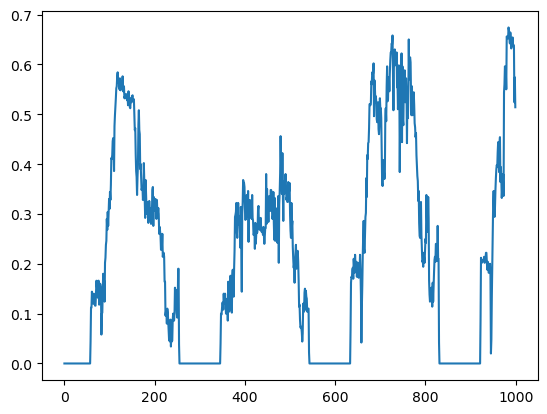

In [62]:
df[0][:1000].plot()

In [63]:
df_truncated = df[~condition]
df_truncated.reset_index(inplace=True, drop=True)
# df_truncated = df_truncated.dropna()
df_truncated

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,Timestamp
0,0.112,0.150,0.048,0.140,0.070,0.064,0.160,0.334,0.088,0.352,...,0.034,0.020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59
1,0.112,0.150,0.006,0.132,0.066,0.068,0.154,0.334,0.086,0.346,...,0.030,0.012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60
2,0.144,0.164,0.028,0.140,0.064,0.074,0.146,0.326,0.084,0.370,...,0.044,0.020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61
3,0.130,0.140,0.014,0.122,0.056,0.074,0.156,0.334,0.090,0.366,...,0.034,0.016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62
4,0.124,0.180,0.036,0.142,0.056,0.074,0.160,0.322,0.090,0.440,...,0.032,0.024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45973,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68216
45974,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68217
45975,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68218
45976,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68219


<Axes: >

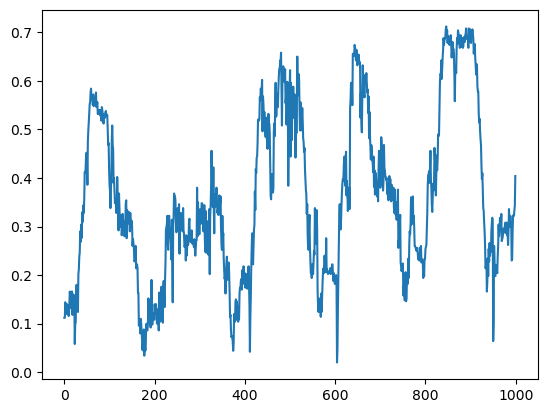

In [64]:
df_truncated[0][:1000].plot()

In [65]:
df_truncated = df_truncated.drop(['Timestamp'], axis=1)

In [66]:
np.save("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/data.npy", df_truncated)

In [67]:
data_tensor = torch.tensor(np.load("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/data.npy"), dtype=torch.float)
data_tensor.shape

torch.Size([45978, 42])

In [68]:
data_tensor = data_tensor.reshape([data_tensor.shape[0], data_tensor.shape[1], 1, 1])
data_tensor.shape

torch.Size([45978, 42, 1, 1])

In [69]:
np.save("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/data.npy", data_tensor.numpy())

### Time feature

In [70]:
time_df = pd.read_csv("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/time_features.txt", delimiter=" ", header=None)
time_df

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68251,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
68252,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
68253,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
68254,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [71]:
time_df_truncated = time_df[~condition]

In [72]:
time_df_truncated.shape

(45978, 31)

In [73]:
time_df_truncated.to_csv("stgan-algo/STGAN/ximantis_smooth_3_truncated/data/time_features.txt", sep=" ", header=False, index=False)